<a href="https://colab.research.google.com/github/Zhiyuan-03/AI_in_Transportation_Exercise/blob/main/Project1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Descriptive analysis

In [2]:
from google.colab import files

# Upload files
uploaded = files.upload()

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error
from sklearn.multioutput import MultiOutputRegressor
from lightgbm import LGBMRegressor
from tensorflow.keras import models, layers
from tensorflow.keras import callbacks



# Read the dataset
df = pd.read_csv('Dataset-PT.csv', skiprows=1)


In [4]:
# Basic structure
print(df.info())
print(df.head())

# Summary statistics for numeric features
print(df.describe())

# Missing values
print(df.isna().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545103 entries, 0 to 545102
Data columns (total 31 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   calendar_date                      545103 non-null  int64  
 1   route_id                           545103 non-null  int64  
 2   bus_id                             545103 non-null  int64  
 3   stop_sequence                      545103 non-null  int64  
 4   arrival_delay                      545103 non-null  int64  
 5   dwell_time                         545103 non-null  int64  
 6   travel_time_for_previous_section   545103 non-null  int64  
 7   scheduled_travel_time              545103 non-null  int64  
 8   upstream_stop_delay                545103 non-null  int64  
 9   origin_delay                       545103 non-null  int64  
 10  previous_bus_delay                 545103 non-null  int64  
 11  previous_trip_travel_time          5451

In [5]:
print(df.columns.tolist())


['calendar_date', 'route_id', 'bus_id', 'stop_sequence', 'arrival_delay', 'dwell_time', 'travel_time_for_previous_section', 'scheduled_travel_time', 'upstream_stop_delay', 'origin_delay', 'previous_bus_delay', 'previous_trip_travel_time', 'traffic_condition', 'recurrent_delay', 'weather', 'temperature', 'day_of_week', 'time_of_day', 'factor(weather)Light_Rain', 'factor(weather)Light_Snow', 'factor(weather)Normal', 'factor(weather)Rain', 'factor(weather)Snow', 'factor(temperature)Cold', 'factor(temperature)Extra_cold', 'factor(temperature)Normal', 'factor(day_of_week)weekday', 'factor(day_of_week)weekend', 'factor(time_of_day)Afternoon_peak', 'factor(time_of_day)Morning_peak', 'factor(time_of_day)Off-peak']


In [6]:
cat_cols = ['day_of_week', 'time_of_day', 'weather', 'temperature']
for col in cat_cols:
    print(f"\n{col} distribution:")
    print(df[col].value_counts(normalize=True)*100)



day_of_week distribution:
day_of_week
weekday    76.71009
weekend    23.28991
Name: proportion, dtype: float64

time_of_day distribution:
time_of_day
OP    62.643023
AP    20.867799
MP    16.489177
Name: proportion, dtype: float64

weather distribution:
weather
Normal        94.472237
Light Rain     2.446877
Light Snow     1.783149
Snow           0.678587
Rain           0.619149
Name: proportion, dtype: float64

temperature distribution:
temperature
Normal        86.933479
Cold          11.273466
Extra cold     1.793056
Name: proportion, dtype: float64


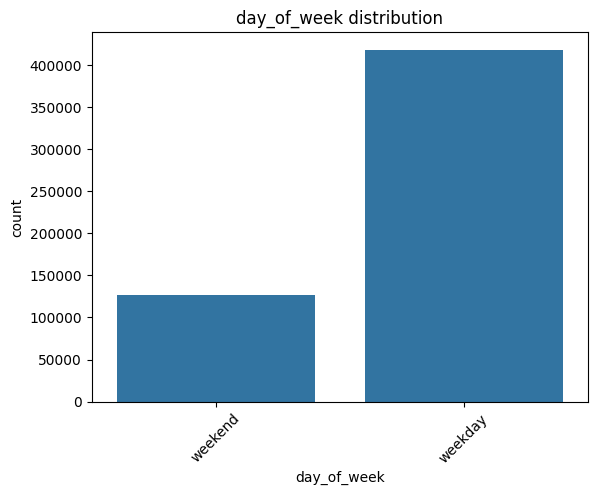

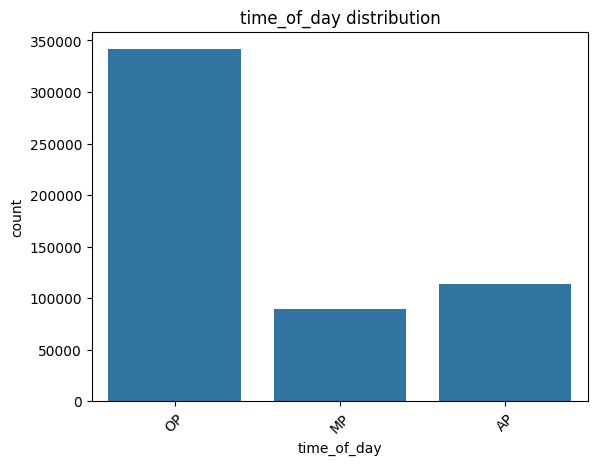

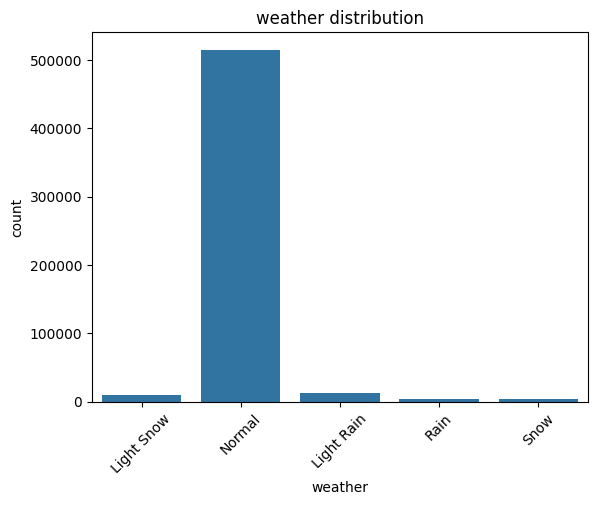

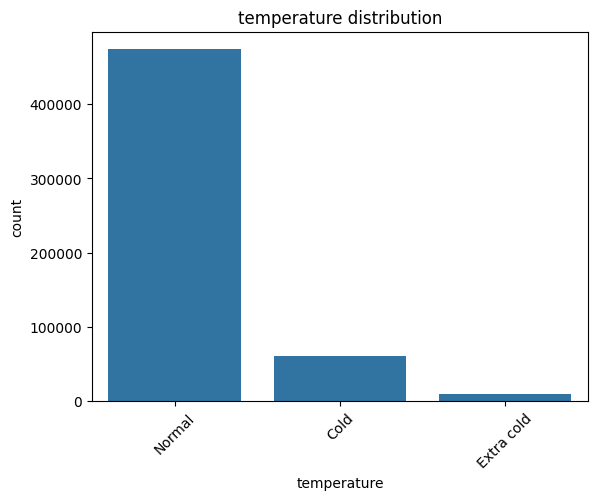

In [7]:
for col in cat_cols:
    sns.countplot(data=df, x=col)
    plt.title(f"{col} distribution")
    plt.xticks(rotation=45)
    plt.show()


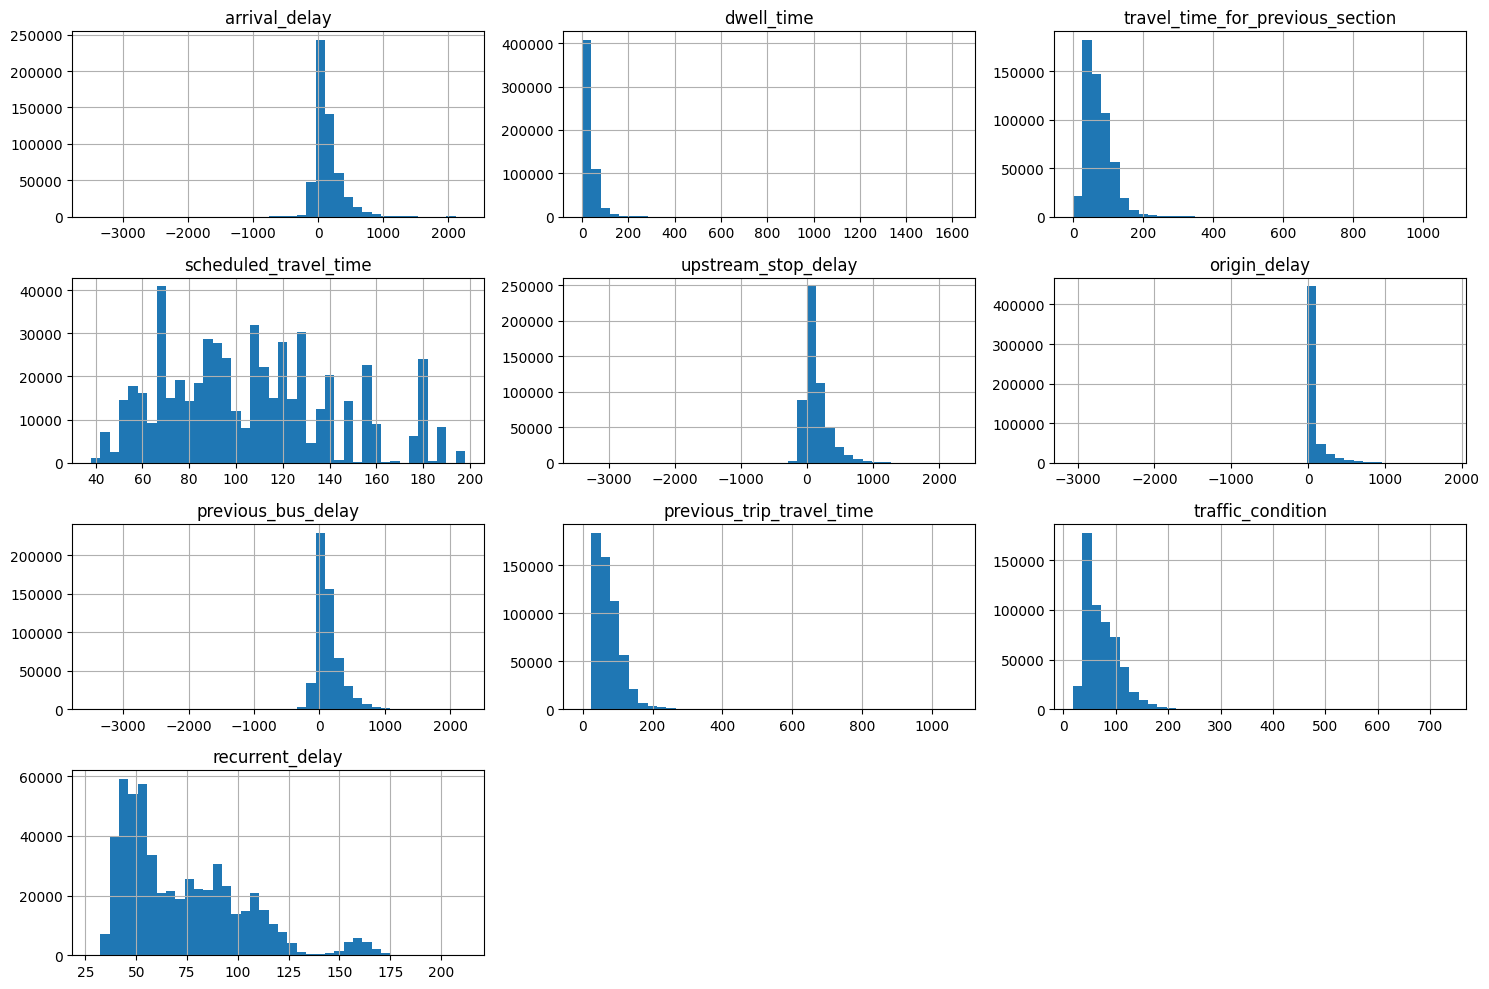

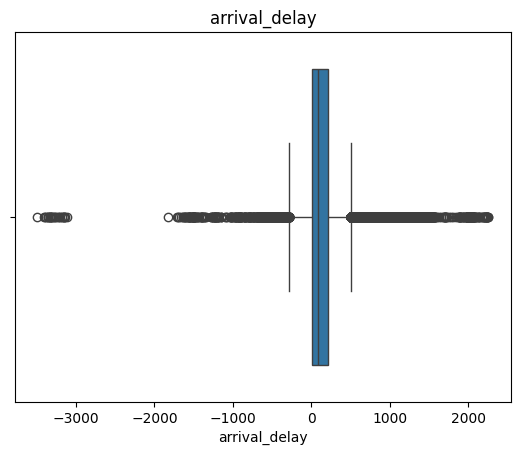

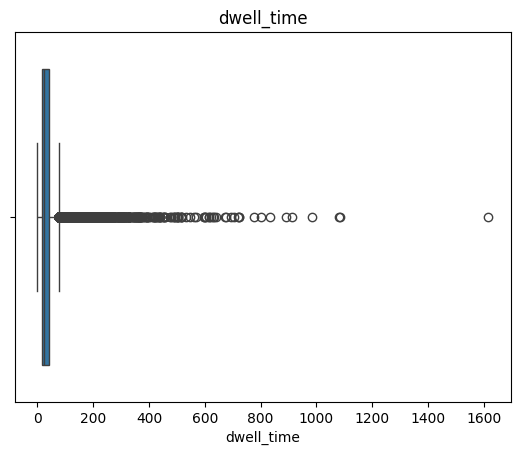

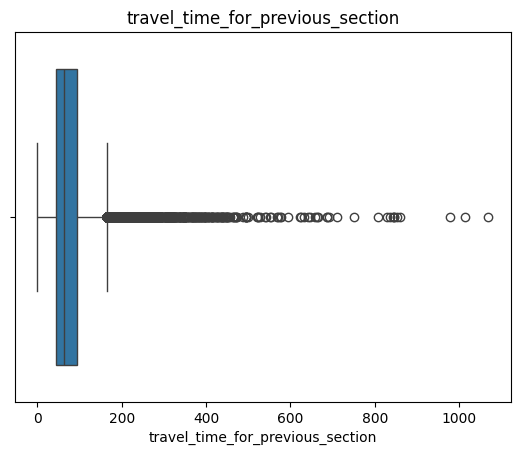

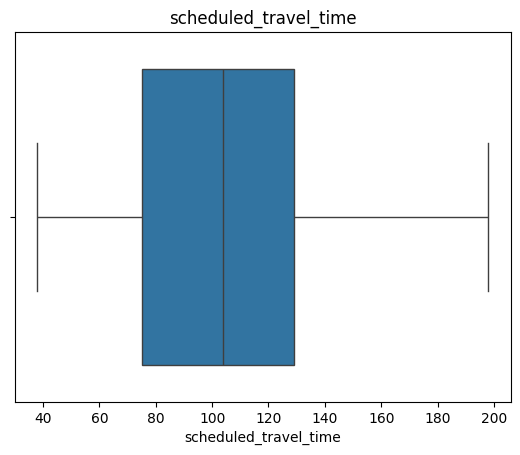

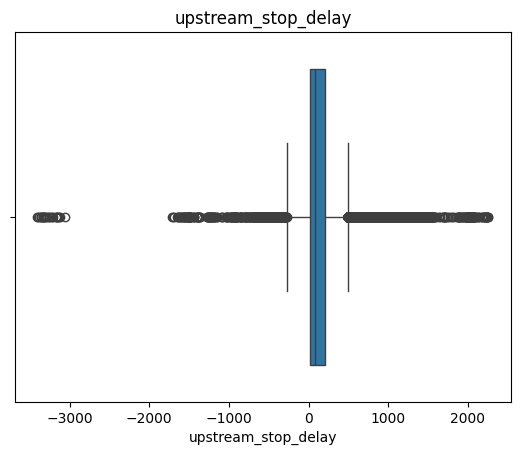

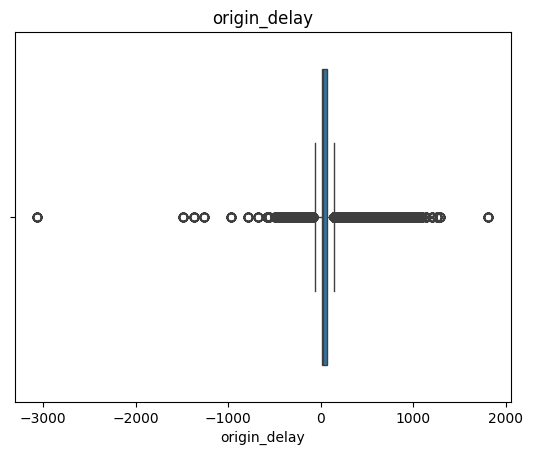

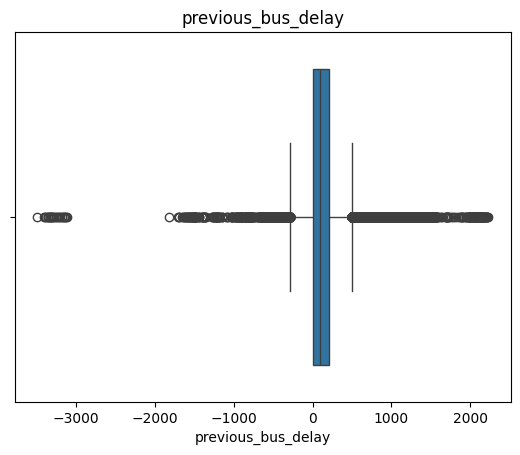

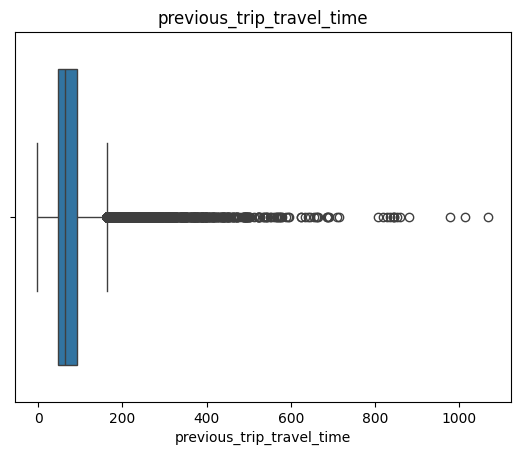

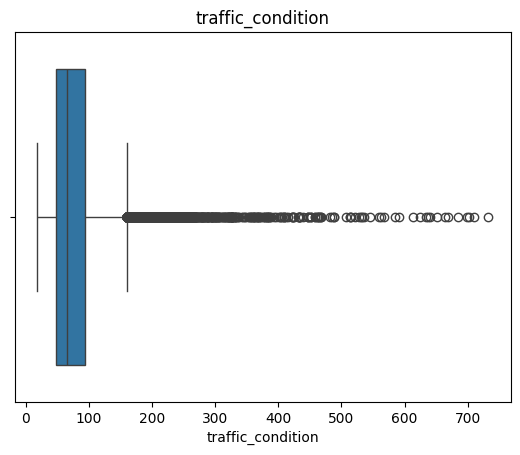

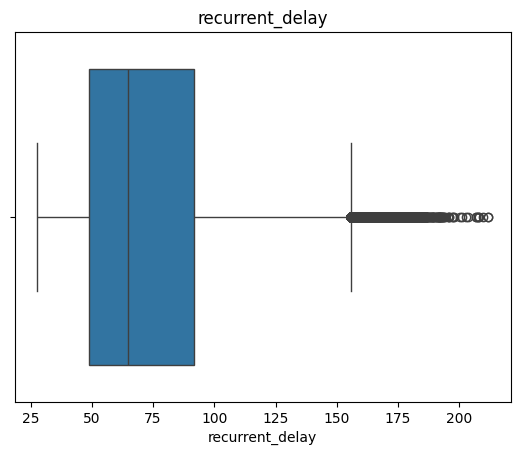

In [8]:
num_cols = [
    'arrival_delay','dwell_time','travel_time_for_previous_section',
    'scheduled_travel_time','upstream_stop_delay','origin_delay',
    'previous_bus_delay','previous_trip_travel_time',
    'traffic_condition','recurrent_delay'
]

# Histograms & boxplots
df[num_cols].hist(bins=40, figsize=(15,10))
plt.tight_layout()
plt.show()

for col in num_cols:
    sns.boxplot(x=df[col])
    plt.title(col)
    plt.show()


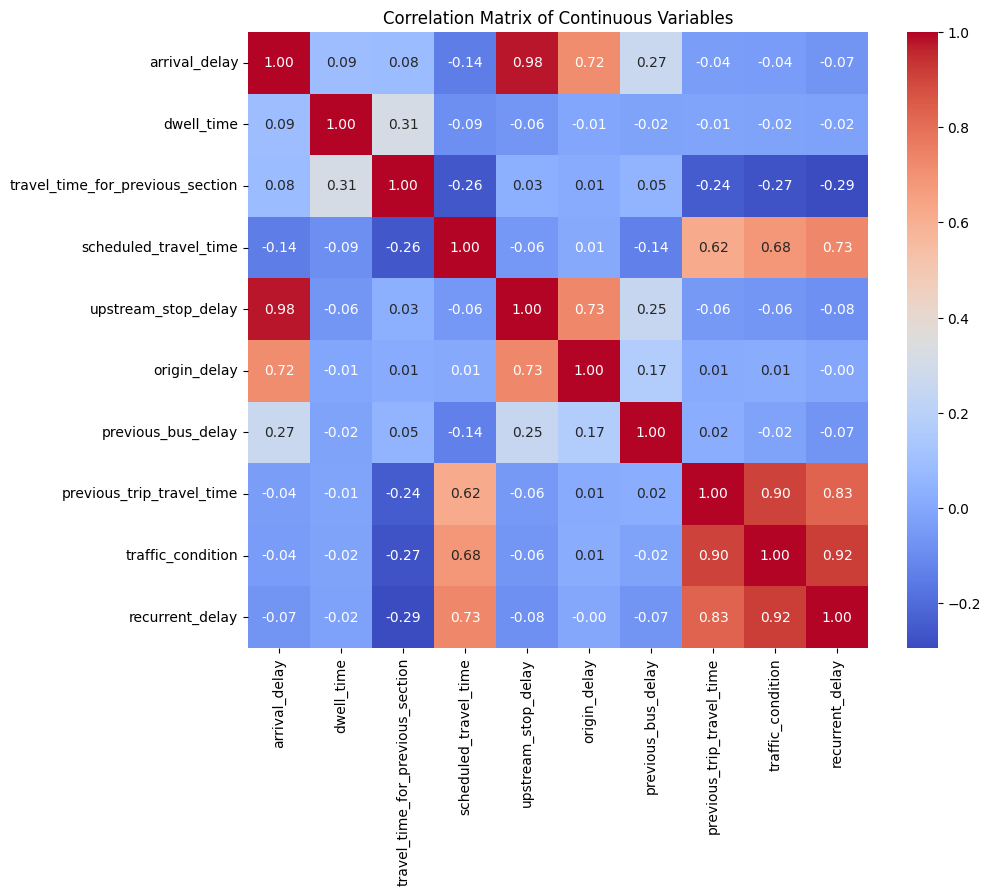

In [9]:
corr = df[num_cols].corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix of Continuous Variables")
plt.show()


In [10]:
df.groupby('time_of_day')['arrival_delay'].describe()


,count,mean,std,min,25%,50%,75%,max
time_of_day,,,,,,,,
AP,113751.0,100.254890,186.904289,-1656.0,-12.0,54.0,166.0,1605.0
MP,89883.0,100.345238,177.431529,-3493.0,-2.0,69.0,172.0,2210.0
OP,341469.0,155.652042,197.356115,-1349.0,26.0,105.0,233.0,2257.0


In [11]:
df.groupby('weather')['arrival_delay'].mean().sort_values()


,arrival_delay
weather,
Light Rain,101.520843
Light Snow,116.779733
Snow,131.268992
Normal,136.034216
Rain,161.584593


In [12]:
df.groupby('day_of_week')['arrival_delay'].mean()


,arrival_delay
day_of_week,
weekday,114.589024
weekend,202.108527


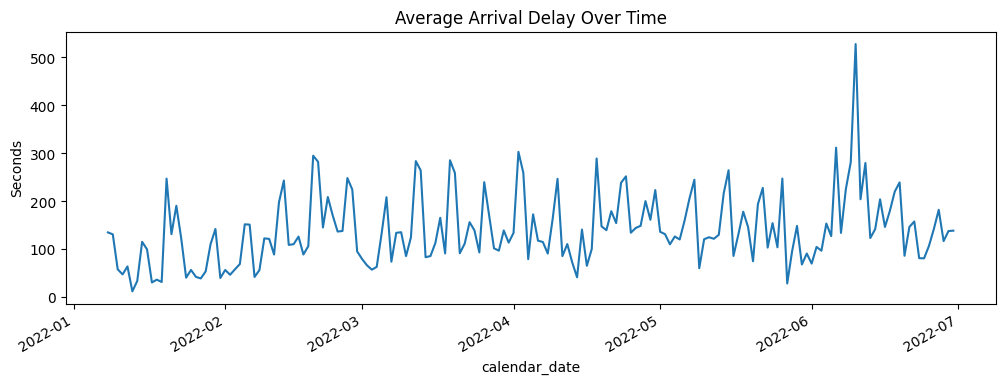

In [13]:
df['calendar_date'] = pd.to_datetime(df['calendar_date'], format='%Y%m%d')
daily_delay = df.groupby('calendar_date')['arrival_delay'].mean()
daily_delay.plot(figsize=(12,4))
plt.title("Average Arrival Delay Over Time")
plt.ylabel("Seconds")
plt.show()


In [14]:
for col in num_cols:
    q1, q3 = df[col].quantile([0.25, 0.75])
    iqr = q3 - q1
    outliers = df[(df[col] < q1 - 1.5*iqr) | (df[col] > q3 + 1.5*iqr)]
    print(f"{col}: {len(outliers)} outliers")


arrival_delay: 28835 outliers
dwell_time: 30726 outliers
travel_time_for_previous_section: 9689 outliers
scheduled_travel_time: 0 outliers
upstream_stop_delay: 29886 outliers
origin_delay: 77571 outliers
previous_bus_delay: 29062 outliers
previous_trip_travel_time: 10476 outliers
traffic_condition: 9228 outliers
recurrent_delay: 14260 outliers


Data Preprocessing

In [15]:
# Missing values count
print(df.isna().sum())

# Example strategies
# Drop rows with too many missing values
df.dropna(thresh=len(df.columns)-3, inplace=True)  # allow ≤3 NaNs per row

# Fill numeric NaNs with median
num_cols = df.select_dtypes(include=[np.number]).columns
df[num_cols] = df[num_cols].fillna(df[num_cols].median())

# Fill categorical NaNs with mode
cat_cols = df.select_dtypes(include='object').columns
df[cat_cols] = df[cat_cols].fillna(df[cat_cols].mode().iloc[0])


calendar_date                        0
route_id                             0
bus_id                               0
stop_sequence                        0
arrival_delay                        0
dwell_time                           0
travel_time_for_previous_section     0
scheduled_travel_time                0
upstream_stop_delay                  0
origin_delay                         0
previous_bus_delay                   0
previous_trip_travel_time            0
traffic_condition                    0
recurrent_delay                      0
weather                              0
temperature                          0
day_of_week                          0
time_of_day                          0
factor(weather)Light_Rain            0
factor(weather)Light_Snow            0
factor(weather)Normal                0
factor(weather)Rain                  0
factor(weather)Snow                  0
factor(temperature)Cold              0
factor(temperature)Extra_cold        0
factor(temperature)Normal

In [16]:
df.drop_duplicates(inplace=True)


In [17]:
if 'calendar_date' in df.columns:
    df['calendar_date'] = pd.to_datetime(df['calendar_date'], format='%Y%m%d')


In [18]:
for col in num_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')


In [19]:
cat_cols = ['day_of_week', 'time_of_day', 'weather', 'temperature']
df = pd.get_dummies(df, columns=cat_cols, drop_first=True)


In [20]:
from sklearn.preprocessing import StandardScaler

# Define numeric features to scale
num_cols = [
    'arrival_delay','dwell_time','travel_time_for_previous_section',
    'scheduled_travel_time','upstream_stop_delay','origin_delay',
    'previous_bus_delay','previous_trip_travel_time',
    'traffic_condition','recurrent_delay'
]

scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])


In [21]:
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545103 entries, 0 to 545102
Data columns (total 36 columns):
 #   Column                             Non-Null Count   Dtype         
---  ------                             --------------   -----         
 0   calendar_date                      545103 non-null  datetime64[ns]
 1   route_id                           545103 non-null  int64         
 2   bus_id                             545103 non-null  int64         
 3   stop_sequence                      545103 non-null  int64         
 4   arrival_delay                      545103 non-null  float64       
 5   dwell_time                         545103 non-null  float64       
 6   travel_time_for_previous_section   545103 non-null  float64       
 7   scheduled_travel_time              545103 non-null  float64       
 8   upstream_stop_delay                545103 non-null  float64       
 9   origin_delay                       545103 non-null  float64       
 10  previous_bus_delay  

In [22]:
# Parse calendar_date (already in 'YYYY-MM-DD' format)
df["calendar_date"] = pd.to_datetime(df["calendar_date"], format="%Y-%m-%d")

# Estimate scheduled arrival time assuming service starts at 6:00 AM (21600 seconds)
df["scheduled_dt"] = df["calendar_date"] + pd.to_timedelta(21600 + df["scheduled_travel_time"], unit="s")

# Estimate actual arrival time by adding delay
df["actual_arrival_dt"] = df["scheduled_dt"] + pd.to_timedelta(df["arrival_delay"], unit="s")

# Extract calendar components
df["year"]       = df["calendar_date"].dt.year
df["month"]      = df["calendar_date"].dt.month
df["day"]        = df["calendar_date"].dt.day
df["dayofweek"]  = df["calendar_date"].dt.dayofweek  # 0 = Monday
df["is_weekend"] = df["dayofweek"].isin([5, 6]).astype(int)

# Extract hour of actual arrival
df["arrival_hour"] = df["actual_arrival_dt"].dt.hour


In [23]:
# Relative position along the 28-stop route
df['route_progress'] = df['stop_sequence'] / 28

In [24]:
# Sort by bus, date, and stop sequence to ensure chronological order
df = df.sort_values(["bus_id", "calendar_date", "stop_sequence"])

# Initialize tracking variables
trip_ids = []
trip_counter = 0
last_bus_date = (None, None)
last_stop_seq = None

# Iterate through rows to assign trip keys
for _, row in df.iterrows():
    current_key = (row["bus_id"], row["calendar_date"].date())
    stop_seq = row["stop_sequence"]

    # Detect new trip: either a new bus-date combo or a reset in stop sequence
    if current_key != last_bus_date or (last_stop_seq is not None and stop_seq <= last_stop_seq):
        trip_counter += 1

    trip_ids.append(f"{current_key[0]}_{current_key[1]}_{trip_counter}")
    last_bus_date = current_key
    last_stop_seq = stop_seq

# Assign trip_key to DataFrame
df["trip_key"] = trip_ids


Feature Engineering

In [25]:
df["hour"] = df["actual_arrival_dt"].dt.hour
df["hour_sin"] = np.sin(2*np.pi*df["hour"]/24)
df["hour_cos"] = np.cos(2*np.pi*df["hour"]/24)
# One-hot categorical features
for col in ["day_of_week", "time_of_day", "weather", "temperature"]:
    if col in df.columns:
        df = pd.concat([df, pd.get_dummies(df[col], prefix=col)], axis=1)
        # Identify one-hot encoded columns
weather_cols = [c for c in df.columns if c.startswith("weather_")]
time_cols = [c for c in df.columns if c.startswith("time_of_day_")]

# Create interaction terms
for w in weather_cols:
    for t in time_cols:
        interaction_name = f"{w}_x_{t}"
        df[interaction_name] = df[w] * df[t]


feature_cols = ["stop_sequence","hour_sin","hour_cos"] + \
               [c for c in df.columns if c.startswith(("day_of_week_","time_of_day_","weather_","temperature_"))] + \
               [c for c in [    "upstream_stop_delay",    # ADVANCED ITS
    "origin_delay",
    "previous_bus_delay",
    "recurrent_delay",
    "scheduled_travel_time",
    "travel_time_for_previous_section",
    "dwell_time",
    "traffic_condition",
    "previous_trip_travel_time"]
                if c in df.columns]
                # Add interaction terms to feature list
interaction_features = [f"{w}_x_{t}" for w in weather_cols for t in time_cols]
feature_cols += interaction_features

In [26]:
# ---------- 3. Build Samples with recurrent_next_h ----------
rows, targets, masks, meta = [], [], [], []
max_len = 27   # downstream stops (28 total stops → 27 max ahead)

# Ensure recurrent_delay exists
if 'recurrent_delay' not in df.columns:
    df['recurrent_delay'] = 0.0

for trip, g in df.groupby("trip_key"):
    g = g.sort_values("stop_sequence").reset_index(drop=True)
    n = len(g)
    if n < 2:
        continue

    delays = g["arrival_delay"].values.astype(float)
    recs   = g["recurrent_delay"].values.astype(float)

    for k in range(n-1):
        cur = g.loc[k]
        feat = {}

        # ---- Base features ----
        feat["stop_sequence"] = cur["stop_sequence"]
        feat["hour_sin"] = cur["hour_sin"]
        feat["hour_cos"] = cur["hour_cos"]
        if "route_progress" in g.columns:
            feat["route_progress"] = cur["route_progress"]

        # one-hot / categorical features already expanded
        for c in [c for c in df.columns if c.startswith(("day_of_week_","time_of_day_","weather_","temperature_"))]:
            feat[c] = cur[c]

        # ITS features if available
        for c in [
            "upstream_stop_delay","origin_delay","previous_bus_delay",
            "scheduled_travel_time","travel_time_for_previous_section",
            "dwell_time","traffic_condition","previous_trip_travel_time"
        ]:
            if c in g.columns:
                feat[c] = cur[c]

        # ---- Add recurrent delay for each downstream stop ----
        downstream_recs = recs[k+1:]
        for h, val in enumerate(downstream_recs, start=1):
            feat[f"recurrent_next_{h}"] = val
        pad_len = max_len - len(downstream_recs)
        for h in range(len(downstream_recs)+1, max_len+1):
            feat[f"recurrent_next_{h}"] = 0.0

        # ---- Targets: downstream actual delays ----
        y = delays[k+1:].tolist()
        targets.append(y + [0]*pad_len)
        masks.append([1]*len(y) + [0]*pad_len)

        rows.append(feat)
        meta.append((trip, int(cur["stop_sequence"])))

# Convert to arrays
X = pd.DataFrame(rows).fillna(0)
Y = np.array(targets)
MASK = np.array(masks)


In [27]:
# ---------- 4. Temporal Split -------------
# ✅ NEW (optimized)
trip_date_map = df.groupby("trip_key")["calendar_date"].first().to_dict()
dates = [trip_date_map[m[0]] for m in meta]
dates = pd.to_datetime(dates)

train_idx = dates.month.isin([1, 2, 3, 4])
val_idx   = dates.month == 5
test_idx  = dates.month == 6


X_train, y_train, mask_train = X[train_idx], Y[train_idx], MASK[train_idx]
X_val,   y_val,   mask_val   = X[val_idx],   Y[val_idx],   MASK[val_idx]
X_test,  y_test,  mask_test  = X[test_idx],  Y[test_idx],  MASK[test_idx]

print("Train/Val/Test:", X_train.shape, X_val.shape, X_test.shape)

Train/Val/Test: (72696, 56) (18538, 56) (15704, 56)


In [28]:
# ---------- Linear Multi-Output ------
from sklearn.linear_model import LinearRegression
from sklearn.multioutput import MultiOutputRegressor
def masked_mae(y_true, y_pred, mask):
  return [
      mean_absolute_error(y_true[mask[:, i] == 1, i], y_pred[mask[:, i] == 1, i])
      if mask[:, i].sum() > 0 else np.nan
      for i in
      range(y_true.shape[1]) ]
# Train linear regression model for each horizon
linreg = MultiOutputRegressor(LinearRegression())
linreg.fit(X_train, y_train)

# Predict on test set
pred_linreg = linreg.predict(X_test)

# Evaluate MAE per horizon using the same masked logic
mae_linreg = masked_mae(y_test, pred_linreg, mask_test)

# Print first 10 horizons
print("Linear Regression MAE per horizon:", mae_linreg[:10])


Linear Regression MAE per horizon: [0.7174663514759853, 0.7598038604050407, 0.7766038207895943, 0.7916405286883562, 0.8071526549423795, 0.8186551566272204, 0.8312111050033226, 0.8421201392697355, 0.854149216478539, 0.8630787961602602]


True Delay Vector (seconds): [ 33.          29.          77.         140.         183.
 183.         159.         244.         263.         263.
 233.         248.         236.         232.         202.
 235.         299.         299.         273.         262.
 245.         218.         202.         234.         241.
 193.         134.97223827]
Predicted Delay Vector (seconds): [ 44.02940413  78.9672964   35.84301849  83.61688426  97.04937962
  85.44421085  56.38037204  94.71281402 127.4804403   82.48918868
  48.84757345 139.07597344 139.65587484 143.94609199 109.18273286
 159.65482665 191.61157219 192.7777358  149.10438668 142.45915029
 136.77660565 124.74206164  98.35042691 124.72068318 116.31652181
  13.71565442 134.97223827]
Valid Mask: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0]

✅ RMSE: 112.40 seconds
✅ MAE: 105.04 seconds
✅ MAPE: 54.52%


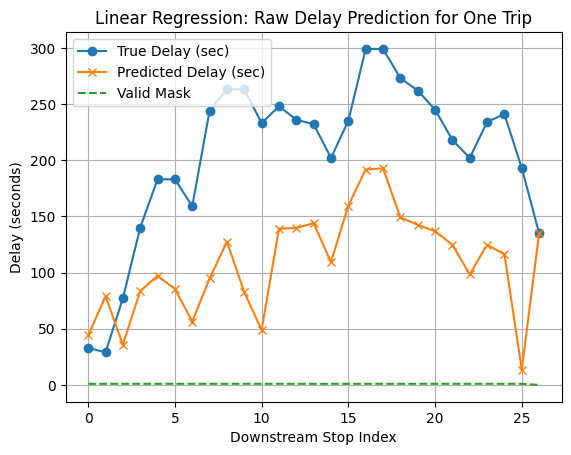

In [29]:
from sklearn.linear_model import LinearRegression
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Load original, unscaled data
df_raw = pd.read_csv('Dataset-PT.csv', skiprows=1)

# Fit scaler on raw arrival_delay values
scaler_arrival = StandardScaler()
scaler_arrival.fit(df_raw[['arrival_delay']])

# Train linear regression model
linreg = MultiOutputRegressor(LinearRegression())
linreg.fit(X_train, y_train)

# Predict on test set
pred_linreg = linreg.predict(X_test)

# Choose a sample index
i = 0

# Inverse transform predictions and ground truth
true_raw = scaler_arrival.inverse_transform(y_test[i].reshape(-1, 1)).flatten()
pred_raw = scaler_arrival.inverse_transform(pred_linreg[i].reshape(-1, 1)).flatten()
mask = mask_test[i].astype(bool)

# Filter valid entries
true_valid = true_raw[mask]
pred_valid = pred_raw[mask]

# Compute metrics
rmse = np.sqrt(mean_squared_error(true_valid, pred_valid))
mae = mean_absolute_error(true_valid, pred_valid)
mape = np.mean(np.abs((true_valid - pred_valid) / np.maximum(np.abs(true_valid), 1e-5))) * 100

# Print results
print("True Delay Vector (seconds):", true_raw)
print("Predicted Delay Vector (seconds):", pred_raw)
print("Valid Mask:", mask_test[i])
print(f"\n✅ RMSE: {rmse:.2f} seconds")
print(f"✅ MAE: {mae:.2f} seconds")
print(f"✅ MAPE: {mape:.2f}%")

# Plot
plt.plot(true_raw, label="True Delay (sec)", marker='o')
plt.plot(pred_raw, label="Predicted Delay (sec)", marker='x')
plt.plot(mask_test[i], label="Valid Mask", linestyle="--")
plt.title("Linear Regression: Raw Delay Prediction for One Trip")
plt.xlabel("Downstream Stop Index")
plt.ylabel("Delay (seconds)")
plt.legend()
plt.grid(True)
plt.show()


In [30]:
# ---------- 6. LightGBM Multi-Output ------
lgb = MultiOutputRegressor(LGBMRegressor(n_estimators=200, learning_rate=0.05))
lgb.fit(X_train, y_train)
pred_lgb = lgb.predict(X_test)
print("LightGBM MAE per horizon:", masked_mae(y_test, pred_lgb, mask_test)[:10])


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021365 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8403
[LightGBM] [Info] Number of data points in the train set: 72696, number of used features: 55
[LightGBM] [Info] Start training from score -0.066009
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019172 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8403
[LightGBM] [Info] Number of data points in the train set: 72696, number of used features: 55
[LightGBM] [Info] Start training from score -0.017076
[LightGBM] [Warning] Found

True Delay Vector (seconds): [ 33.          29.          77.         140.         183.
 183.         159.         244.         263.         263.
 233.         248.         236.         232.         202.
 235.         299.         299.         273.         262.
 245.         218.         202.         234.         241.
 193.         134.97223827]
Predicted Delay Vector (seconds): [ 27.37409167  35.22361613  11.94819723  38.23483123  65.10281034
  61.38072356  24.92091607  81.60427799  97.0101148   78.22456965
  56.14028858 156.04878643 116.39601434 151.81902739 136.5746877
 173.60643537 240.81978491 258.93735483 226.05184577 173.78982777
 205.38943376 162.44119116 134.8916283  159.7606616  150.44862436
  83.58728294 134.97223827]
Valid Mask: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0]

✅ RMSE: 101.48 seconds
✅ MAE: 89.64 seconds
✅ MAPE: 44.31%


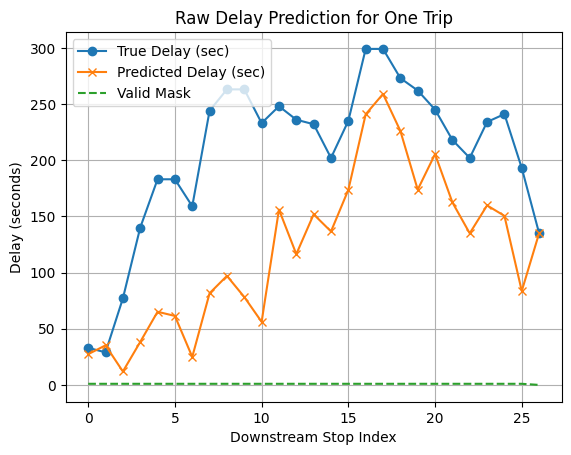

In [31]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

df_raw = pd.read_csv('Dataset-PT.csv', skiprows=1)

scaler_arrival = StandardScaler()
scaler_arrival.fit(df_raw[['arrival_delay']])  # now using truly unscaled data


i = 0  # sample index

# Inverse transform predictions and ground truth
true_raw = scaler_arrival.inverse_transform(y_test[i].reshape(-1, 1)).flatten()
pred_raw = scaler_arrival.inverse_transform(pred_lgb[i].reshape(-1, 1)).flatten()
mask = mask_test[i].astype(bool)

# Filter valid entries
true_valid = true_raw[mask]
pred_valid = pred_raw[mask]

# Compute metrics
rmse = np.sqrt(mean_squared_error(true_valid, pred_valid))
mae = mean_absolute_error(true_valid, pred_valid)
mape = np.mean(np.abs((true_valid - pred_valid) / np.maximum(np.abs(true_valid), 1e-5))) * 100

# Print results
print("True Delay Vector (seconds):", true_raw)
print("Predicted Delay Vector (seconds):", pred_raw)
print("Valid Mask:", mask_test[i])
print(f"\n✅ RMSE: {rmse:.2f} seconds")
print(f"✅ MAE: {mae:.2f} seconds")
print(f"✅ MAPE: {mape:.2f}%")

# Plot
plt.plot(true_raw, label="True Delay (sec)", marker='o')
plt.plot(pred_raw, label="Predicted Delay (sec)", marker='x')
plt.plot(mask_test[i], label="Valid Mask", linestyle="--")
plt.title("Raw Delay Prediction for One Trip")
plt.xlabel("Downstream Stop Index")
plt.ylabel("Delay (seconds)")
plt.legend()
plt.grid(True)
plt.show()


In [34]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error

def masked_mae(y_true, y_pred, mask):
    """MAE per horizon (same as before). Returns list per horizon."""
    return [
        mean_absolute_error(y_true[mask[:, i] == 1, i], y_pred[mask[:, i] == 1, i])
        if mask[:, i].sum() > 0 else np.nan
        for i in range(y_true.shape[1])
    ]

def aggregate_masked(mae_list):
    """Return a single scalar average MAE across horizons (ignoring NaNs)."""
    return np.nanmean(mae_list)

def evaluate_model_preds(y_true, y_pred, mask, name="model"):
    per_h = masked_mae(y_true, y_pred, mask)
    overall = aggregate_masked(per_h)
    print(f"{name} overall MAE: {overall:.2f} s")
    return per_h


LightGBM overall MAE: 0.69 s


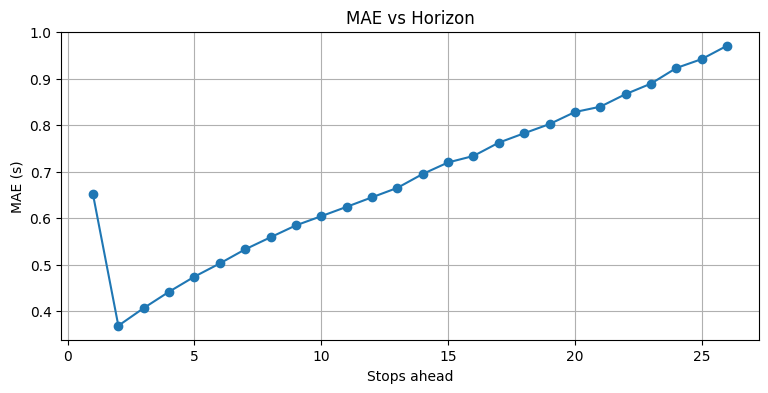

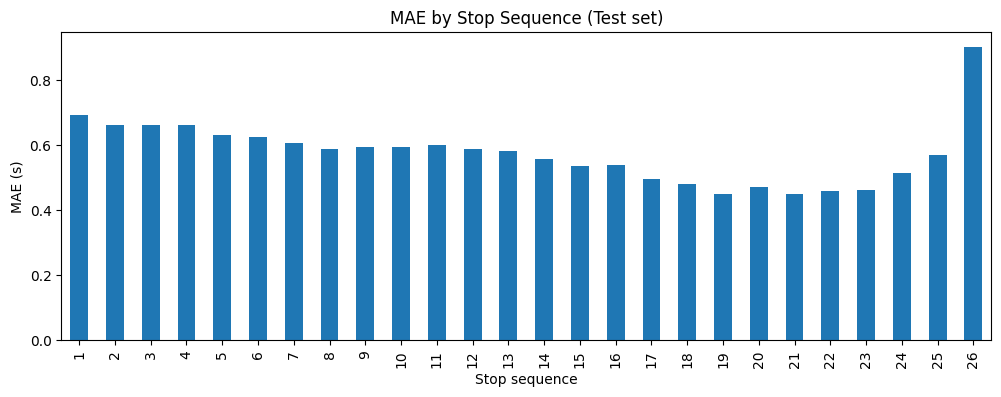

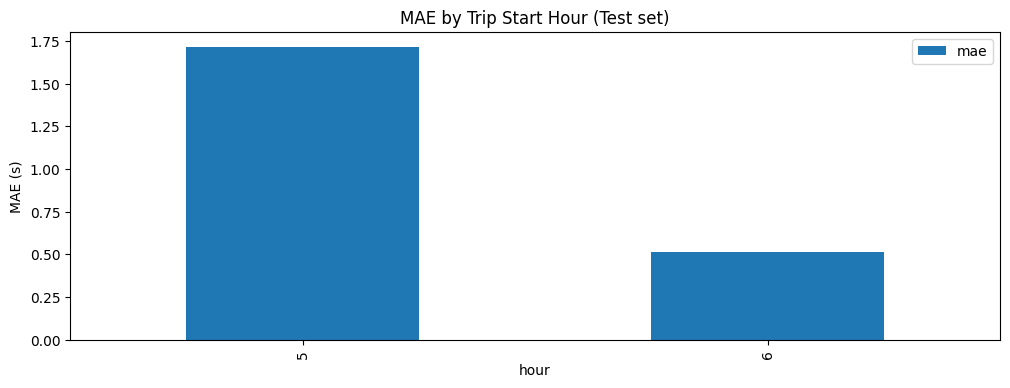

KeyboardInterrupt: 

In [35]:
# choose prediction to analyze (LightGBM example)
pred = pred_lgb   # or pred_seq, pred_linreg
per_h = evaluate_model_preds(y_test, pred, mask_test, name="LightGBM")

# 1a: MAE vs horizon (plot)
import matplotlib.pyplot as plt
mae_horizons = per_h
plt.figure(figsize=(9,4))
plt.plot(range(1, len(mae_horizons)+1), mae_horizons, marker='o')
plt.xlabel("Stops ahead")
plt.ylabel("MAE (s)")
plt.title("MAE vs Horizon")
plt.grid(True)
plt.show()

# 1b: MAE by stop_sequence (where along route errors cluster)
stop_seq_all = np.array([m[1] for m in meta])
stop_seq_test = stop_seq_all[test_idx]
unique_stops = np.unique(stop_seq_test)
mae_by_stop = []
for s in unique_stops:
    idx = (stop_seq_test == s)
    if idx.sum()==0: continue
    y_s, p_s, m_s = y_test[idx], pred[idx], mask_test[idx]
    mae_s = masked_mae(y_s, p_s, m_s)
    mae_by_stop.append((s, np.nanmean(mae_s)))
mae_stop_df = pd.DataFrame(mae_by_stop, columns=["stop_seq","mae"])
mae_stop_df.set_index("stop_seq", inplace=True)
mae_stop_df.plot(kind="bar", figsize=(12,4), legend=False)
plt.xlabel("Stop sequence")
plt.ylabel("MAE (s)")
plt.title("MAE by Stop Sequence (Test set)")
plt.show()






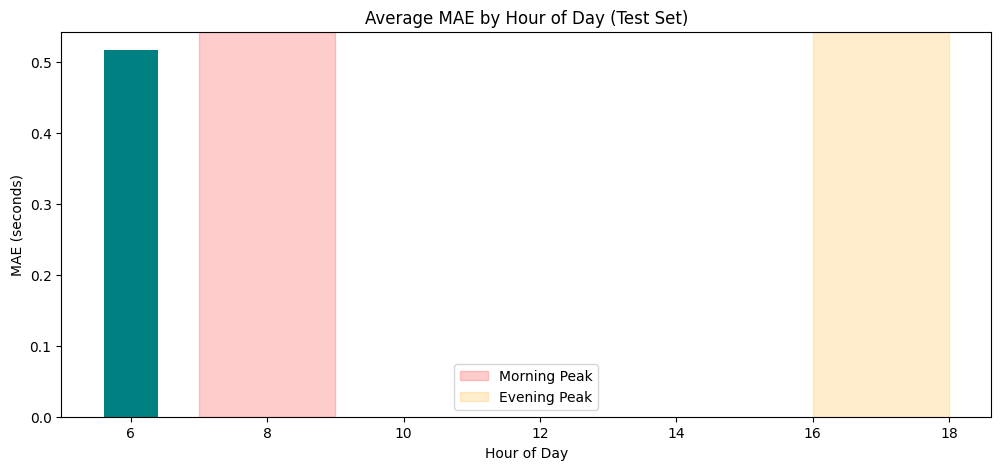

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/v

Clean Test MAE: 0.69
With Noise (10% Gaussian) MAE: 0.71
With Missing Features (20% zeroed) MAE: 0.77


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
import random

# ----------------- Helper -----------------
def masked_mae(y_true, y_pred, mask):
    return [
        mean_absolute_error(y_true[mask[:, i] == 1, i], y_pred[mask[:, i] == 1, i])
        if mask[:, i].sum() > 0 else np.nan
        for i in range(y_true.shape[1])
    ]

# ----------------- 1. Performance vs Time of Day -----------------
# Map trip_key -> first arrival datetime
trip_first_time = df.groupby("trip_key")["actual_arrival_dt"].first().astype("datetime64[ns]")
sample_hours = np.array([trip_first_time[m[0]].hour for m in meta])

# Restrict to test set
sample_hours_test = sample_hours[test_idx]

pred_mae, hour_bins = [], []
for h in range(6, 23):   # service hours 6am–10pm
    idx = (sample_hours_test == h)
    if idx.sum() == 0:
        continue
    y_h, p_h, m_h = y_test[idx], pred[idx], mask_test[idx]
    mae_h = masked_mae(y_h, p_h, m_h)
    pred_mae.append(np.nanmean(mae_h))
    hour_bins.append(h)

plt.figure(figsize=(12,5))
plt.bar(hour_bins, pred_mae, color="teal")
plt.axvspan(7, 9, color="red", alpha=0.2, label="Morning Peak")
plt.axvspan(16, 18, color="orange", alpha=0.2, label="Evening Peak")
plt.title("Average MAE by Hour of Day (Test Set)")
plt.xlabel("Hour of Day")
plt.ylabel("MAE (seconds)")
plt.legend()
plt.show()

# ----------------- 2. Robustness Checks -----------------
from copy import deepcopy

def robustness_check(model, X_test, y_test, mask_test, scenario="noise"):
    """
    scenario: 'noise' (add Gaussian noise to features)
              'missing' (randomly drop some features)
    """
    X_mod = deepcopy(X_test.values)

    if scenario == "noise":
        noise = np.random.normal(0, 0.1, size=X_mod.shape)  # 10% std noise
        X_mod = X_mod + noise
    elif scenario == "missing":
        drop_rate = 0.2  # drop 20% of entries
        mask = np.random.rand(*X_mod.shape) < drop_rate
        X_mod[mask] = 0

    preds = model.predict(X_mod)
    mae_vals = masked_mae(y_test, preds, mask_test)
    return np.nanmean(mae_vals)

# Run robustness tests
mae_clean = np.nanmean(masked_mae(y_test, pred, mask_test))
mae_noise = robustness_check(lgb, X_test, y_test, mask_test, "noise")
mae_missing = robustness_check(lgb, X_test, y_test, mask_test, "missing")

print("Clean Test MAE:", round(mae_clean, 2))
print("With Noise (10% Gaussian) MAE:", round(mae_noise, 2))
print("With Missing Features (20% zeroed) MAE:", round(mae_missing, 2))


In [38]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error

# Helper: masked MAE per horizon (same as previous)
def masked_mae(y_true, y_pred, mask):
    return [
        mean_absolute_error(y_true[mask[:, i] == 1, i], y_pred[mask[:, i] == 1, i])
        if mask[:, i].sum() > 0 else np.nan
        for i in range(y_true.shape[1])
    ]

# Build sample -> date mapping using meta and df
trip_date_map = df.groupby("trip_key")["calendar_date"].first().to_dict()
sample_dates = np.array([trip_date_map[m[0]] for m in meta])  # length = n_samples
sample_dates = pd.to_datetime(sample_dates)

# Define folds: choose month-level rolling origin
# Example: use all months except last as potential train_end; test the following month
months = pd.Series(sample_dates).dt.to_period("M").sort_values().unique()
months = list(months)  # e.g., [Period('2022-01'), Period('2022-02'), ...]
if len(months) < 3:
    raise ValueError("Need at least 3 months for robust rolling evaluation.")

fold_results = []  # list of dicts: {'train_end':..., 'test_month':..., 'mae_horizon':[...]}

# Choose minimum train months (e.g., at least 2 months for first fold)
min_train_months = 2

# iterate train_end indices such that test_month exists after train_end
for i in range(min_train_months - 1, len(months) - 1):
    train_end = months[i]            # inclusive
    test_month = months[i + 1]       # one-month-ahead test
    # select indices
    train_idx = (pd.Series(sample_dates).dt.to_period("M") <= train_end).values
    test_idx  = (pd.Series(sample_dates).dt.to_period("M") == test_month).values
    if test_idx.sum() < 50:
        # skip tiny test sets
        continue

    X_train_fold = X[train_idx]
    y_train_fold = Y[train_idx]
    mask_train_fold = MASK[train_idx]

    X_test_fold = X[test_idx]
    y_test_fold = Y[test_idx]
    mask_test_fold = MASK[test_idx]

    # Fit a fresh model on this fold OR reuse your global model (choose one).
    # I'll show fitting LightGBM on fold (you can substitute with linear/LSTM).
    from lightgbm import LGBMRegressor
    from sklearn.multioutput import MultiOutputRegressor

    model = MultiOutputRegressor(LGBMRegressor(
        n_estimators=200,
        learning_rate=0.05,
        num_leaves=64,
        random_state=42,
        n_jobs=-1
    ))
    model.fit(X_train_fold.values, y_train_fold)

    y_pred_fold = model.predict(X_test_fold.values)

    mae_h = masked_mae(y_test_fold, y_pred_fold, mask_test_fold)
    fold_results.append({
        "train_end": str(train_end),
        "test_month": str(test_month),
        "mae_horizon": mae_h,
        "n_test": int(test_idx.sum())
    })
    print(f"Fold train_end={train_end} test={test_month} n_test={test_idx.sum()} overall_mae={np.nanmean(mae_h):.2f}")

# Aggregate results across folds
# Stack per-horizon into array [n_folds, num_horizons]
mae_matrix = np.array([fr["mae_horizon"] for fr in fold_results])
horizon_mean = np.nanmean(mae_matrix, axis=0)
horizon_std  = np.nanstd(mae_matrix, axis=0)

# Example print for first 10 horizons
for h in range(10):
    print(f"Horizon {h+1}: MAE = {horizon_mean[h]:.2f} ± {horizon_std[h]:.2f} s")

# Optionally save fold_results to DataFrame
#rows = []
#for fr in fold_results:
#    for h, val in enumerate(fr["mae_horizon"], start=1):
#        rows.append({"train_end":fr["train_end"], "test_month":fr["test_month"], "horizon":h, "mae":val, "n_test":fr["n_test"]})
#fold_df = pd.DataFrame(rows)
#fold_df.to_csv("rolling_origin_mae_by_fold.csv", index=False)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.111779 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8019
[LightGBM] [Info] Number of data points in the train set: 33306, number of used features: 55
[LightGBM] [Info] Start training from score -0.118662
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007440 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8019
[LightGBM] [Info] Number of data points in the train set: 33306, number of used features: 55
[LightGBM] [Info] Start training from score -0.035467
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007512 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not eno

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/v

Fold train_end=2022-02 test=2022-03 n_test=20722 overall_mae=0.49
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013086 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8294
[LightGBM] [Info] Number of data points in the train set: 54028, number of used features: 55
[LightGBM] [Info] Start training from score -0.105144
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012904 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8294
[LightGBM] [Info] Number of data points in the train set: 54028, number of used features: 55
[LightGBM] [Info] Start training from score -0.024168
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012681 seconds.
You can set `for

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/v

Fold train_end=2022-03 test=2022-04 n_test=18668 overall_mae=0.50
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.050179 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8403
[LightGBM] [Info] Number of data points in the train set: 72696, number of used features: 55
[LightGBM] [Info] Start training from score -0.066009
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017391 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8403
[LightGBM] [Info] Number of data points in the train set: 72696, number of used features: 55
[LightGBM] [Info] Start training from score -0.017076
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017059 seconds.
You can set `for

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/v

Fold train_end=2022-04 test=2022-05 n_test=18538 overall_mae=0.52
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021460 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8490
[LightGBM] [Info] Number of data points in the train set: 91234, number of used features: 55
[LightGBM] [Info] Start training from score -0.073051
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.063737 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8490
[LightGBM] [Info] Number of data points in the train set: 91234, number of used features: 55
[LightGBM] [Info] Start training from score -0.012076
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021288 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not e

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/v

Fold train_end=2022-05 test=2022-06 n_test=15704 overall_mae=0.68
Horizon 1: MAE = 0.58 ± 0.05 s
Horizon 2: MAE = 0.24 ± 0.07 s
Horizon 3: MAE = 0.28 ± 0.07 s
Horizon 4: MAE = 0.31 ± 0.07 s
Horizon 5: MAE = 0.34 ± 0.07 s
Horizon 6: MAE = 0.37 ± 0.07 s
Horizon 7: MAE = 0.40 ± 0.07 s
Horizon 8: MAE = 0.42 ± 0.07 s
Horizon 9: MAE = 0.45 ± 0.07 s
Horizon 10: MAE = 0.47 ± 0.07 s


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/tmp/ipython-input-3090284949.py:77: RuntimeWarning: Mean of empty slice
  horizon_mean = np.nanmean(mae_matrix, axis=0)
/usr/local/lib/python3.12/dist-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


In [40]:
def simulate_noise(feature_name, sigmas=[0.1,0.5,1.0,2.0]):
    # sigma is expressed relative to feature std
    X_test_arr = X_test.copy().astype(float)
    std = X_test_arr[feature_name].std()
    results = {}
    for s in sigmas:
        X_mod = X_test_arr.copy()
        noise = np.random.RandomState(0).normal(0, s*std, size=len(X_mod))
        X_mod[feature_name] += noise
        pred_mod = lgb.predict(X_mod.values)
        mae = aggregate_masked(masked_mae(y_test, pred_mod, mask_test))
        results[s] = mae
        print(f"Noise {s} sigma -> MAE {mae:.2f}")
    return results

# Example: noise on upstream_stop_delay
if "upstream_stop_delay" in X_test.columns:
    simulate_noise("upstream_stop_delay", sigmas=[0.1,0.5,1.0])


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/v

Noise 0.1 sigma -> MAE 0.70


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/v

Noise 0.5 sigma -> MAE 0.85


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/v

Noise 1.0 sigma -> MAE 1.03


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


In [32]:
# ---------- 7. LSTM Seq2Seq ---------------
def build_seq_data(X_df, Y_arr, mask_arr):
    Xarr = X_df.values.astype(np.float32)
    n, f = Xarr.shape
    Xseq = np.repeat(Xarr[:,None,:], max_len, axis=1)        # [n,max_len,f]
    Yseq = Y_arr[:,:max_len].reshape(n,max_len,1)
    return Xseq, Yseq, mask_arr[:,:max_len]

Xtr_s, ytr_s, mtr_s = build_seq_data(X_train, y_train, mask_train)
Xv_s,  yv_s,  mv_s  = build_seq_data(X_val,   y_val,   mask_val)
Xte_s, yte_s, mte_s = build_seq_data(X_test,  y_test,  mask_test)

model = models.Sequential([
    layers.Masking(mask_value=0., input_shape=(max_len, Xtr_s.shape[2])),
    layers.LSTM(128, return_sequences=True),
    layers.TimeDistributed(layers.Dense(1))
])
model.compile(optimizer="adam", loss="mae")
model.fit(Xtr_s, ytr_s, validation_data=(Xv_s, yv_s),
          epochs=30, batch_size=64,
          callbacks=[callbacks.EarlyStopping(patience=5, restore_best_weights=True)])

pred_seq = model.predict(Xte_s).reshape(Xte_s.shape[0], max_len)
print("LSTM MAE per horizon:", masked_mae(y_test, pred_seq, mask_test)[:10])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/masking.py:48: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
1136/1136 ━━━━━━━━━━━━━━━━━━━━ 84s 71ms/step - loss: 0.0930 - val_loss: 0.0783
Epoch 2/30
1136/1136 ━━━━━━━━━━━━━━━━━━━━ 79s 70ms/step - loss: 0.0674 - val_loss: 0.0707
Epoch 3/30
1136/1136 ━━━━━━━━━━━━━━━━━━━━ 85s 72ms/step - loss: 0.0630 - val_loss: 0.0681
Epoch 4/30
1136/1136 ━━━━━━━━━━━━━━━━━━━━ 81s 71ms/step - loss: 0.0573 - val_loss: 0.0593
Epoch 5/30
1136/1136 ━━━━━━━━━━━━━━━━━━━━ 80s 70ms/step - loss: 0.0523 - val_loss: 0.0559
Epoch 6/30
1136/1136 ━━━━━━━━━━━━━━━━━━━━ 79s 70ms/step - loss: 0.0501 - val_loss: 0.0546
Epoch 7/30
1136/1136 ━━━━━━━━━━━━━━━━━━━━ 79s 69ms/step - loss: 0.0474 - val_loss: 0.0560
Epoch 8/30
1136/1136 ━━━━━━━━━━━━━━━━━━━━ 86s 75ms/step - loss: 0.0463 - val_loss: 0.0510
Epoch 9/30
1136/1136 ━━━━━━━━━━━━━━━━━━━━ 79s 69ms/step - loss: 0.0451 - val_loss: 0.0499
Epoch 10/30
1136/1136 ━━━━━━━━━━━━━━━━━━━━ 83s 73ms/step - loss: 0.0439 - val_loss: 0.0489
Epoch 11/30
1136/1136 ━━━━━━━━━━━━━━━━━━━━ 83s 73ms/step - loss: 0.0436 - val_loss: 0.0490
Epoch 12

True Delay Vector (seconds): [ 33.          29.          77.         140.         183.
 183.         159.         244.         263.         263.
 233.         248.         236.         232.         202.
 235.         299.         299.         273.         262.
 245.         218.         202.         234.         241.
 193.         134.97223827]
Predicted Delay Vector (seconds): [ 49.219     29.016405  24.701609  42.228233  59.12123   62.385246
  63.86042   67.777794  72.39048   77.33181   84.46854   95.05156
 108.72973  122.203835 131.546    154.80978  183.5824   190.8553
 179.19453  165.49841  155.65968  150.99362  152.3069   147.78099
 133.52213   98.253716 128.22455 ]
Valid Mask: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0]

✅ RMSE: 111.72 seconds
✅ MAE: 102.15 seconds
✅ MAPE: 48.45%


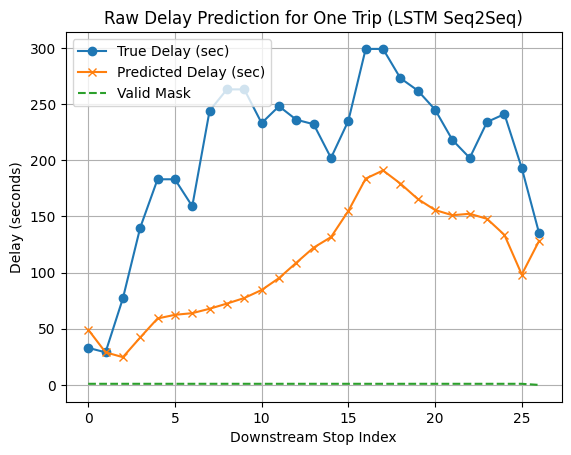

In [33]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Load original, unscaled data
df_raw = pd.read_csv('Dataset-PT.csv', skiprows=1)

# Fit scaler on raw arrival_delay values
scaler_arrival = StandardScaler()
scaler_arrival.fit(df_raw[['arrival_delay']])

i = 0  # sample index

# Replace pred_lgb with your LSTM predictions
# Ensure pred_seq is shaped like (num_samples, num_horizons)
true_raw = scaler_arrival.inverse_transform(y_test[i].reshape(-1, 1)).flatten()
pred_raw = scaler_arrival.inverse_transform(pred_seq[i].reshape(-1, 1)).flatten()
mask = mask_test[i].astype(bool)

# Filter valid entries
true_valid = true_raw[mask]
pred_valid = pred_raw[mask]

# Compute metrics
rmse = np.sqrt(mean_squared_error(true_valid, pred_valid))
mae = mean_absolute_error(true_valid, pred_valid)
mape = np.mean(np.abs((true_valid - pred_valid) / np.maximum(np.abs(true_valid), 1e-5))) * 100

# Print results
print("True Delay Vector (seconds):", true_raw)
print("Predicted Delay Vector (seconds):", pred_raw)
print("Valid Mask:", mask_test[i])
print(f"\n✅ RMSE: {rmse:.2f} seconds")
print(f"✅ MAE: {mae:.2f} seconds")
print(f"✅ MAPE: {mape:.2f}%")

# Plot
plt.plot(true_raw, label="True Delay (sec)", marker='o')
plt.plot(pred_raw, label="Predicted Delay (sec)", marker='x')
plt.plot(mask_test[i], label="Valid Mask", linestyle="--")
plt.title("Raw Delay Prediction for One Trip (LSTM Seq2Seq)")
plt.xlabel("Downstream Stop Index")
plt.ylabel("Delay (seconds)")
plt.legend()
plt.grid(True)
plt.show()
